# 第8章：モデル構築の準備

## 8.1 他にどのような特徴量が作れるだろうか？考えてチームで議論してみよう。

### 【解答例】

- 以下のような議論があった。
    - 種子島さん「商品を購入する人は売場にやってきたら商品をすぐに手に取りそうだよね。逆に商品を購入する気が無い人は、売場にきてもなかなか商品を手に取らないんじゃないかな。」
    - 内之浦さん「それなら、売場にやってきてから商品を手に取るまでの時間を計測してみると、なにか特長がありそうかもね。」
- 上記の議論から「フレームイン時刻（売場にやってきた）から最初に商品を接触するまでの時刻までの時間」を特徴量として追加することとした。

### 【解説】

- まずは、どのような特徴量が作れそうか各自で考えてみましょう。その際にEDAの結果を参考にするとよいでしょう。
- 次に、そのアイデアを各自で発表しあうと良いでしょう。声が大きい人（よくしゃべる人）の意見だけではなく、あまりしゃべらない人の意見も議論で取り上げると良いでしょう。挙手制にするのではなく「○○さんから時計回りで発表してみましょう」などとするのも良いでしょう。各自が各自の意見を発表することが大切です。

## 8.2 実際に特徴量を実装してDataFrameに追加してみよう。

### 【解答例】

- 途中までは書籍本編と同様の処理を実行する。

In [ ]:
import numpy as np
import pandas as pd

gi_train_mm10_df = pd.read_csv("../input/gi_train_mm10.csv") # 10月のデータ
gi_train_mm11_df = pd.read_csv("../input/gi_train_mm11.csv") # 11月のデータ

# pandasのconcatで結合する
gi_train_df = pd.concat([gi_train_mm10_df, gi_train_mm11_df], axis=0)
pp_gi_train_df = gi_train_df[gi_train_df["customer_id"].notna()].copy()

# 各event_typeごとのDataFrameを作成
pp_gi_train_df_et1 = pp_gi_train_df[pp_gi_train_df["event_type"] == 1]
pp_gi_train_df_et2 = pp_gi_train_df[pp_gi_train_df["event_type"] == 2]
pp_gi_train_df_et3 = pp_gi_train_df[pp_gi_train_df["event_type"] == 3]

In [ ]:
contact_list = pp_gi_train_df_et3["customer_id"].drop_duplicates()
contact_list

In [ ]:
pp_gi_train_df_et1_rev = pp_gi_train_df_et1[pp_gi_train_df_et1["customer_id"].isin(contact_list)]
pp_gi_train_df_et1_rev.head()

In [ ]:
pp_gi_train_df_et2_rev = pp_gi_train_df_et2[pp_gi_train_df_et2["customer_id"].isin(contact_list)]
pp_gi_train_df_et2_rev.head()

In [ ]:
output_df = pp_gi_train_df_et1_rev[["customer_id", "event_day", "gender", "age", "time_duration"]].copy()
output_df

In [ ]:
# カテゴリ変数をまとめたリスト
cate_cols = ["event_day", "gender", "age"]
# ダミー変数化
output_df = pd.get_dummies(data=output_df, columns=cate_cols)
output_df

In [ ]:
# エリアIDのリストを数値型で作成
area_id_list = sorted(pp_gi_train_df_et2_rev["area_id"].astype(int).unique().tolist())
area_id_list

In [ ]:
# areaのtime_duration関連のカラムを格納するリスト
area_time_duration_cols = []

# 各エリアについてループ処理
for tmp_area_id in area_id_list:
    # 当該エリアのtime_durationを取得
    #（この時点ではcustomer_idについて複数レコードが存在する）
    tmp_area_duration_df = pp_gi_train_df_et2_rev[pp_gi_train_df_et2_rev["area_id"]==tmp_area_id][["customer_id", "time_duration"]]
    # そのうちcusotmer_idごとに最大値を取得する
    tmp_area_duration_df = tmp_area_duration_df.groupby(by=["customer_id"]).max().reset_index(drop=False)

    # カラム名を指定する
    tmp_area_max_time_duration_col = f"area{tmp_area_id}_max_time_duration"
    area_time_duration_cols += [tmp_area_max_time_duration_col]
    tmp_area_duration_df = tmp_area_duration_df.rename(columns={"time_duration": tmp_area_max_time_duration_col})
    
    # customer_idをキーとしてoutput_dfに結合する
    output_df = pd.merge(output_df, tmp_area_duration_df, on=["customer_id"], how="left")

In [ ]:
output_df

In [ ]:
area_time_duration_cols

In [ ]:
buy_flag_df = pp_gi_train_df_et3[pp_gi_train_df_et3["buy_flag"] == 1].drop_duplicates(subset="customer_id")[["customer_id", "buy_flag"]].copy()
buy_flag_df

In [ ]:
# マージしてoutput_dfに格納
output_df = pd.merge(output_df, buy_flag_df, on="customer_id", how="left")
# buy_flagについて0埋めとint型への変更を実施
output_df["buy_flag"] = output_df["buy_flag"].fillna(0)
output_df["buy_flag"] = output_df["buy_flag"].astype(int)
output_df

In [ ]:
# 木系モデルの欠損値処理（-1埋め）
# エリア1～5についてループを回す
dtc_pp_gi_train_df = output_df.copy()
for col in area_time_duration_cols:
    dtc_pp_gi_train_df[col] = dtc_pp_gi_train_df[col].fillna(-1)

# ロジスティック回帰モデルの欠損値処理（0埋め）
# エリア1～5についてループを回す
lgr_pp_gi_train_df = output_df.copy()
for col in area_time_duration_cols:
    lgr_pp_gi_train_df[col] = lgr_pp_gi_train_df[col].fillna(0)

In [ ]:
dtc_pp_gi_train_df

In [ ]:
lgr_pp_gi_train_df

In [ ]:
# GIのtestデータを読み込む
gi_test_df = pd.read_csv("../input/gi_test.csv")
gi_test_df.head()

In [ ]:
# 各event_typeごとのDataFrameを作成
pp_gi_test_df_et1 = gi_test_df[gi_test_df["event_type"] == 1]
pp_gi_test_df_et2 = gi_test_df[gi_test_df["event_type"] == 2]
pp_gi_test_df_et3 = gi_test_df[gi_test_df["event_type"] == 3]

output_df = pp_gi_test_df_et1[["customer_id", "event_day", "gender", "age", "time_duration"]].copy()

# ダミー変数化
output_df = pd.get_dummies(data=output_df, columns=cate_cols)
output_df

In [ ]:
area_time_duration_cols

In [ ]:
# 各エリアについてループ処理
for tmp_area_id in area_id_list:
    # 当該エリアのtime_durationを取得
    #（この時点ではcustomer_idについて複数レコードが存在する）
    tmp_area_duration_df = pp_gi_test_df_et2[pp_gi_test_df_et2["area_id"]==tmp_area_id][["customer_id", "time_duration"]]
    # そのうちcusotmer_idごとに最大値を取得する
    tmp_area_duration_df = tmp_area_duration_df.groupby(by=["customer_id"]).max().reset_index(drop=False)

    # カラム名を指定する
    tmp_area_max_time_duration_col = f"area{tmp_area_id}_max_time_duration"
    tmp_area_duration_df = tmp_area_duration_df.rename(columns={"time_duration": tmp_area_max_time_duration_col})
    
    # customer_idをキーとしてoutput_dfに結合する
    output_df = pd.merge(output_df, tmp_area_duration_df, on=["customer_id"], how="left")

In [ ]:
output_df

In [ ]:
# 木系モデルの欠損値処理（-1埋め）
# エリア1～5についてループを回す
dtc_pp_gi_test_df = output_df.copy()
for col in area_time_duration_cols:
    dtc_pp_gi_test_df[col] = dtc_pp_gi_test_df[col].fillna(-1)

# ロジスティック回帰モデルの欠損値処理（0埋め）
# エリア1～5についてループを回す
lgr_pp_gi_test_df = output_df.copy()
for col in area_time_duration_cols:
    lgr_pp_gi_test_df[col] = lgr_pp_gi_test_df[col].fillna(0)

In [ ]:
dtc_pp_gi_test_df

In [ ]:
lgr_pp_gi_test_df

- csvファイルとpickleファイル出力のプログラムは省略した。
- ここからが章末問題独自の処理となる。

In [ ]:
# 「フレームイン時刻（売場にやってきた）から最初に商品を接触するまでの時刻までの時間」を算出する関数
def get_diff_time_df(input_df):

    copy_df = input_df.copy()
    copy_df = copy_df[copy_df["in_time"].notnull()]
    copy_df["time"] = copy_df["event_day"].astype(str) + " " + copy_df["in_time"].astype(str)
    
    copy_df["time"] = pd.to_datetime(copy_df["time"])

    # フレームイン時間DataFrame
    frame_in_time_df = copy_df[["customer_id", "event_type", "time"]][
        copy_df["event_type"]==1
    ].drop(
        labels=["event_type"], axis=1
    ).groupby(
        by=["customer_id"]
    ).max().reset_index(drop=False).rename(columns={"time": "frame_in_time"})

    # 商品接触時間DataFrame
    touch_time_df = copy_df[["customer_id", "event_type", "time"]][
        copy_df["event_type"]==3
    ].drop(
        labels=["event_type"], axis=1
    ).groupby(
        by=["customer_id"]
    ).max().reset_index(drop=False).rename(columns={"time": "touch_time"})

    # 2つのDataFrameを結合する
    diff_time_df = pd.merge(
        touch_time_df,
        frame_in_time_df,
        on=["customer_id"],
        how="left"
    )

    # 差分を算出して列を追加する
    diff_time_df["diff_time_frame2touch(s)"] = diff_time_df["touch_time"] - diff_time_df["frame_in_time"]
    diff_time_df["diff_time_frame2touch(s)"] = diff_time_df["diff_time_frame2touch(s)"].apply(lambda x: x.seconds)

    # 念のためshapeの確認
    print("=" * 80)
    print("frame_in_time_df.shape:", frame_in_time_df.shape)
    print("touch_time_df.shape:", touch_time_df.shape)
    print("diff_time_df.shape:", diff_time_df.shape)
    print("=" * 80)
    
    return diff_time_df

In [ ]:
# trainとtestそれぞれのデータに対して、フレームインから商品接触までの時間を計算する
diff_time_train_df = get_diff_time_df(gi_train_df)
diff_time_test_df = get_diff_time_df(gi_test_df)

In [ ]:
# 作成されたDataFrameを確認する
diff_time_train_df.head()

In [ ]:
# 決定木、ロジスティック回帰用のtrain、test用データに特徴量をmergeする
# 章末問題用データ
shomatsu_dtc_pp_gi_train_df = pd.merge(
    dtc_pp_gi_train_df,
    diff_time_train_df[["customer_id", "diff_time_frame2touch(s)"]],
    on="customer_id",
    how="left"
)

shomatsu_dtc_pp_gi_test_df = pd.merge(
    dtc_pp_gi_test_df,
    diff_time_test_df[["customer_id", "diff_time_frame2touch(s)"]],
    on="customer_id",
    how="left"
)

shomatsu_lgr_pp_gi_train_df = pd.merge(
    lgr_pp_gi_train_df,
    diff_time_train_df[["customer_id", "diff_time_frame2touch(s)"]],
    on="customer_id",
    how="left"
)

shomatsu_lgr_pp_gi_test_df = pd.merge(
    lgr_pp_gi_test_df,
    diff_time_test_df[["customer_id", "diff_time_frame2touch(s)"]],
    on="customer_id",
    how="left"
)

In [ ]:
# shapeを確認しておく
# (行数が増えずに列数だけ増えていればOK)
print("dtc_pp_gi_train_df.shape:", dtc_pp_gi_train_df.shape)
print("shomatsu_dtc_pp_gi_train_df.shape:", shomatsu_dtc_pp_gi_train_df.shape)

print("dtc_pp_gi_test_df.shape:", dtc_pp_gi_test_df.shape)
print("shomatsu_dtc_pp_gi_test_df.shape:", shomatsu_dtc_pp_gi_test_df.shape)

print("lgr_pp_gi_train_df.shape:", lgr_pp_gi_train_df.shape)
print("shomatsu_lgr_pp_gi_train_df.shape:", shomatsu_lgr_pp_gi_train_df.shape)

print("lgr_pp_gi_test_df.shape:", lgr_pp_gi_test_df.shape)
print("shomatsu_lgr_pp_gi_test_df.shape:", shomatsu_lgr_pp_gi_test_df.shape)

In [ ]:
# dict型変数に前処理済みデータをまとめて格納する.
shomatsu_pp_data_dict = {"dtc": {"train": shomatsu_dtc_pp_gi_train_df, "test": shomatsu_dtc_pp_gi_test_df},
                "lgr": {"train": shomatsu_lgr_pp_gi_train_df, "test": shomatsu_lgr_pp_gi_test_df}}

In [ ]:
# 出力するpickleのファイルパスを設定
shomatsu_pp_data_dict_pkl_fpath = "../intermediate/shomatsu_pp_data_dict.pkl3"
# joblibを使用して, pickleファイルを出力する
import joblib
joblib.dump(shomatsu_pp_data_dict, shomatsu_pp_data_dict_pkl_fpath, compress=3)

- 「shomatsu_pp_data_dict.pkl3」というファイルがintermediateフォルダに出力されていることを確認しよう

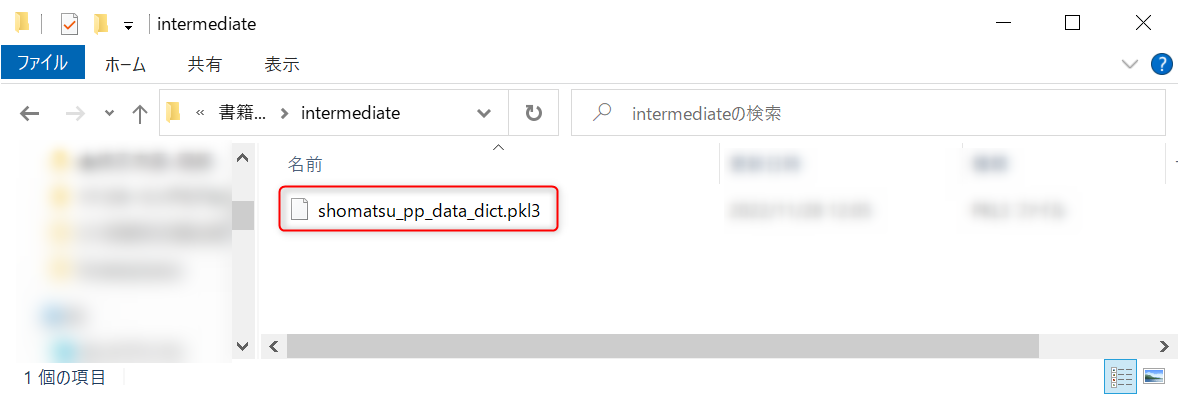

### 【解説】

- 8.1で特徴量をリストアップし、8.2で実際に実装を行いました。このように、まずはどのような特徴量を作れば良さそうかを考えてイメージしておいてから、実際のプログラミングに入ると良いでしょう。そうでないと、プログラミングの途中でどのような特徴量を作るつもりだったのか分からなくなってしまうことがあります。
- 書籍本編にも記載しましたが、特徴量はただ単にたくさん作ればよいというものではありません。特徴量を実装するのもプログラミングに時間がかかりますので、まずはある程度「効きそうな」特徴量を見極めて、優先順位を付けて対応していくと良いでしょう。